# Mock data

In this notebook, I generate mock data employing a set of Gaussian distributions (from 'data/mock_observations.npz').

I add some noise to these Gaussian distributions via Newman's likelihood class.

In [4]:
import math as m
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import multivariate_normal
from scipy.special import gamma

## Load nz data data from
## https://github.com/LSSTDESC/bayesian-pipelines-cosmology/tree/photo-z/notebooks/photo-z/pipeline

In [5]:
data_z = np.load('data/mock_observations.npz')

nz = data_z['nz_truth']
mid = data_z['z_shear']

number_of_bin = 0

# I'm taking the \Sigma_p (present in eq 2) as 3.92; 5.63; 4.68 and 2.60 arc min^-2 respectively for each bin
# That information was taken from arXiv:2211.16516v1; sec 3.1: HSC Y3 Shape Catalog.

if number_of_bin == 0: # bin 1
    nz_bin = nz[0]
    Sigma_p = (3.92*m.pi/(60*180))**(-2) # Mean surface density of objects in p on the sky  (in radians) for bin 1
elif number_of_bin == 1: # bin 2
    nz_bin = nz[1]
    Sigma_p = (5.63*m.pi/(60*180))**(-2) # Mean surface density of objects in p on the sky  (in radians) for bin 2
elif number_of_bin == 2: # bin 3
    nz_bin = nz[2]
    Sigma_p = (4.68*m.pi/(60*180))**(-2) # Mean surface density of objects in p on the sky  (in radians) for bin 3
elif number_of_bin == 3: # bin 4
    nz_bin = nz[3]
    Sigma_p = (2.60*m.pi/(60*180))**(-2) # Mean surface density of objects in p on the sky  (in radians) for bin 4

# Newman's likelihood class 

In [3]:
# All referenced equations come from Newman's paper: https://arxiv.org/abs/0805.1409

def dNs(z): # An approximation of dN_s/dz behavior, it was taken from (roughly calculated by step function) figure 1: spec
        if z < 1.4:
            return 2.5e4
        else:
            return 2e3
dNs = np.vectorize(dNs)

class Likelihood_Newman:
    
    def __init__(self, Omega_m, Omega_k):
        
        """"
        This class construct the mock data and compute the loglike from Jefrey A. Newman's paper
        
        Omega_m: normalized density of total matter in the Universe.
        Omega_k:  normalized curvature density.
        
        All cosmological parameters and quantities show below are called from the package <<astropy.cosmology>> too.
        
        """ 

        self.Omega_m = Omega_m
        self.Omega_k = Omega_k
    
    def E(self, z): # Normalized Hubble parameter -> E(z) = H(z)/H0
        Omega_Lambda = 1 - self.Omega_m
        return np.sqrt( (1+z)**2*self.Omega_m + (1+z)**2*self.Omega_k + Omega_Lambda )
    
    def sigma_err(self, z): # error over phi(z) -> eq (9)
        sigma = ( (3-gamma0)/(2*m.sqrt(m.pi)*Hgamma) )*( (Sigma_p*dNs(z)*delta_z )**(-0.5) )*(
            cosmopar.angular_diameter_distance(z)*c/( cosmopar.H(z)*(r0**gamma0)*rmax**(2-gamma0) )).decompose()
        return sigma
    
    def cov_z(self, sigma_err):
        cov_diag = np.diag(sigma_err**2)
        return cov_diag
    
    def normal(self, mean_array, sigma_err): # Construction of the mock data in terms of phi params
        dist = multivariate_normal(mean_array, self.cov_z(sigma_err)).rvs()
        return dist
    
    def loglike(self, model_s): # loglike in terms of phi params
        model = np.exp(model_s)
        chi2over2 = 0.5*sum( (mock - model)**2/self.sigma_err(mid)**2 )
        return -chi2over2

## Initial values for cosmology and some constants

In [4]:
cosmopar = FlatLambdaCDM(H0 = 67.8, Om0 = 0.3) 

# Fixed values
Om0 = 0.3 # Matter
Omk0 = 0.0 # Flat cosmology
h = cosmopar.H(0).value/100
gamma0 = 1.8
rmax = (10/h)*u.Mpc
r0 = (5/h)*u.Mpc
Hgamma = m.sqrt(m.pi)*( gamma((gamma0-1)/2) / gamma(gamma0/2) ) # H(gamma) is defined in eq. (4)

In [5]:
Lnew = Likelihood_Newman(Om0, Omk0)

## PDF true

In [6]:
pdf_true = nz_bin

delta_z = (max(mid) - min(mid))/len(mid)

pdf_sigmas = Lnew.sigma_err(mid)

## Visualizing the mock data

In [7]:
mock = Lnew.normal(pdf_true, pdf_sigmas)

# save mocks
#np.savetxt('mock_bin1.txt', mock)

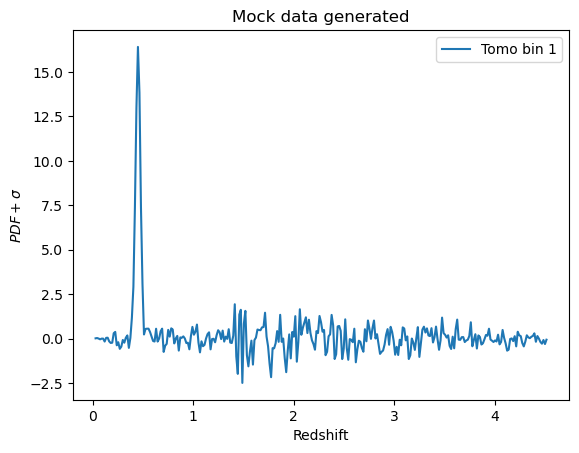

In [8]:
plt.plot(mid, mock, label = "Tomo bin {}".format(number_of_bin+1))

plt.title("Mock data generated")
plt.xlabel("Redshift")
plt.ylabel(r"$PDF+\sigma$")

plt.legend()
plt.show()

## Creating Prior

In [9]:
#from SimpleLogGPModel import PZErrorRBFModel

In [10]:
#model = PZErrorRBFModel(pdf_true, mid, 0.05, num_samp=2000)
#res = model.fit_log_gp_model()

#qrand_sample_list = model.quasi_random_sample(res.x, 2000)
#np.savetxt('priors_bin4.txt', qrand_sample_list)

In [17]:
qrand_sample = np.loadtxt('priors_bin1.txt')

In [18]:
prior_cov = np.cov((qrand_sample).T) 
prior_mean =  np.mean(qrand_sample, axis=0)

In [13]:
X1 = qrand_sample

mu1 = X1.mean(axis=0)
sigma1 = X1.std(axis=0)

print(mu1.shape, sigma1.shape)

(299,) (299,)


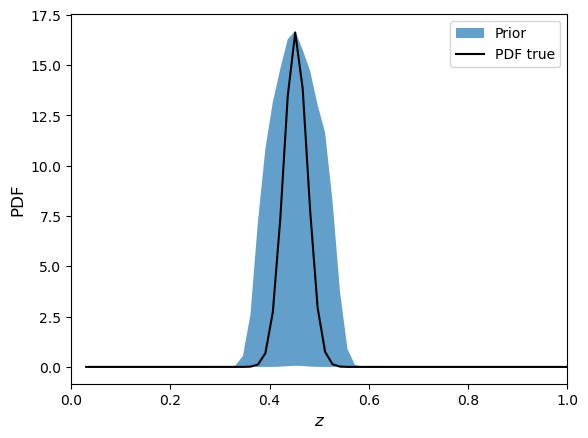

In [14]:
plt.fill_between(mid, np.percentile(qrand_sample, 16, axis=0), np.percentile(qrand_sample, 84, axis=0), label = "Prior", alpha = 0.7)
#plt.fill_between(mid, mu1+3*sigma1, mu1-3*sigma1)

plt.plot(mid, nz[0], 'k', label="PDF true")
#plt.title("Prior for Tomo bin 1")
plt.xlabel(r"$z$", fontsize = 12)
plt.ylabel("PDF", fontsize = 12)

plt.legend()
plt.xlim([0, 1])

plt.savefig("plots/prior_bin1.pdf", format="pdf")

## Variable chance: to s parameters

$$
\begin{aligned}
\boldsymbol{s} & \sim \mathcal{N}\left(\boldsymbol{s} \mid \mu, \Sigma_{\mathrm{CV}}\right) \\
\boldsymbol{\phi}_{\mathrm{nz}} & :=\left\{\left.\frac{\exp \left(s_i\right)}{\sum_j \exp \left(s_j\right)} \right\rvert\, 0<i<N_{\mathrm{bins}}\right\}
\end{aligned}
$$

In [15]:
# I add some perturbation to the prior's diagonal cov matrix to avoid singular behavior
N = len(mid)
epsilon = np.zeros((N,N))
np.fill_diagonal(epsilon, 0.01)

prior_mean_s = np.log(prior_mean) 
prior_cov_s =  np.cov(np.log(qrand_sample).T) + epsilon # cov log or log cov?

In [16]:
prior_mean_s.shape

(299,)

## Sampler: MCMC $\longrightarrow$ Elliptical Slice Sampling

In [17]:
#from DemoHSCAnalysis import EllipticalSliceSampler

In [18]:
#ElliSamp = EllipticalSliceSampler(prior_mean_s, prior_cov_s, Lnew.loglike) # Question: Should we use this loglike instead of loglike Posterior?

In [19]:
#samp_list = ElliSamp.sample(100000)
#np.savetxt('posterior_samp_bin1.txt', samp_list)

In [14]:
model_bin_s = np.loadtxt('posterior_samp_bin1.txt') # 100 000 samples
model_bin = np.exp(model_bin_s) # Returning to phi params

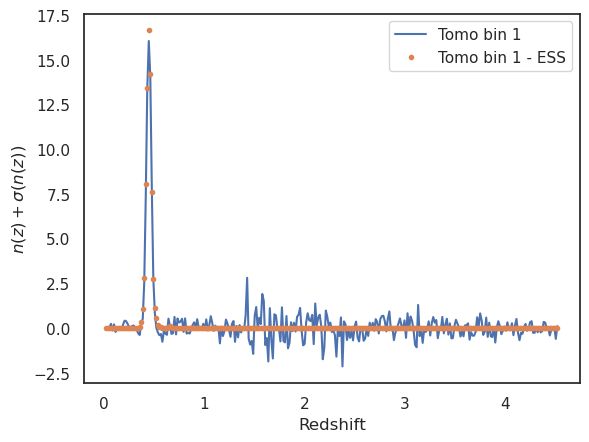

In [15]:
number_sample = 95000 # Checking one particular sample

plt.plot(mid, mock, label='Tomo bin 1')
plt.plot(mid, model_bin[number_sample, :], ".", label = "Tomo bin 1 - ESS")
plt.xlabel("Redshift")
plt.ylabel(r"$n(z) + \sigma(n(z))$")
plt.legend()

plt.savefig("plots/prior_bin1_ESS.pdf", format="pdf")

plt.show()

In [22]:
import random

In [23]:
# Select random samples from 15 000 to 100000
burn_in = 15000

samples_burn_list = model_bin[burn_in:, :]

k = 10000 # I select just 10000 random samples from "burn in = 15000" to " total samples = 100000" 
samples_random_bin = np.take_along_axis(samples_burn_list, np.random.rand(*samples_burn_list.shape).argsort(axis=0)[:k], axis=0)

# the last instruction was taken from: https://stackoverflow.com/questions/70885645/selecting-random-elements-from-each-column-of-numpy-array

In [24]:
# Save the four sampling  for the four tomographic bins with burn in + random selection of the samples

#np.savetxt('samples_bin1.txt', samples_random_bin)

In [25]:
# Save all the information as npz file, I am creting the following directory

#np.savez('results.npz', 
#         z_grid = mid,
#         nz_truth = [nz[0], nz[1], nz[2], nz[3]],
#         mocks = [np.loadtxt('mock_bin1.txt'), np.loadtxt('mock_bin2.txt'), np.loadtxt('mock_bin3.txt'), np.loadtxt('mock_bin4.txt')],
#         samples = [np.loadtxt('samples_bin1.txt'), np.loadtxt('samples_bin2.txt'), np.loadtxt('samples_bin3.txt'), np.loadtxt('samples_bin4.txt')]
#        )

In [7]:
df = np.load('results.npz')

In [8]:
samples_all = df['samples']

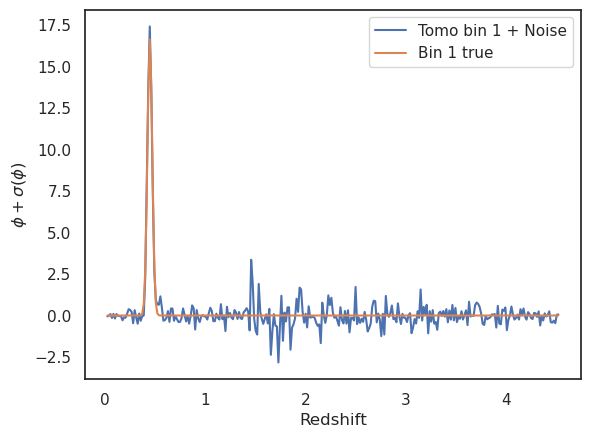

In [9]:
number_sample = 9500 # Checking one particular sample

plt.plot(mid, df["mocks"][0], label='Tomo bin 1 + Noise')
plt.plot(mid, df["nz_truth"][0], label="Bin 1 true")
#plt.plot(mid, samples_all[0][number_sample], ".", label = "Tomo bin 1 - ESS")

plt.xlabel("Redshift")
plt.ylabel(r"$\phi + \sigma(\phi)$")

plt.legend()
plt.show()

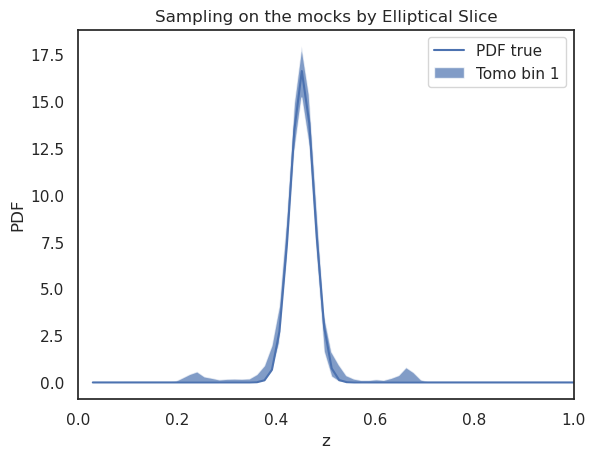

In [10]:
#plt.plot(mid, samples_all[0][500], '.', label='bin 1')

nn = 1

plt.plot(mid, nz[0], label="PDF true")
plt.fill_between(mid, np.percentile(samples_all[0], 0, axis=0), nn*np.percentile(samples_all[0], 100, axis=0), alpha=0.7, label='Tomo bin 1')
#plt.fill_between(mid, np.percentile(samples_all[1], 5, axis=0), nn*np.percentile(samples_all[1], 95, axis=0), label='bin 2')
#plt.fill_between(mid, np.percentile(samples_all[2], 5, axis=0), nn*np.percentile(samples_all[2], 95, axis=0), label='bin 3')
#plt.fill_between(mid, np.percentile(samples_all[3], 5, axis=0), nn*np.percentile(samples_all[3], 95, axis=0), label='bin 4')

plt.title('Sampling on the mocks by Elliptical Slice')
plt.xlabel('z')
plt.ylabel('PDF')
plt.xlim([0,1])

plt.legend()

#plt.savefig("plots/bines.pdf", format="pdf")

In [11]:
import seaborn as sns

In [13]:
df = np.load('results.npz')

samples_all = df['samples']
qrand_sample = np.loadtxt('priors_bin1.txt')

/home/david98z/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/david98z/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


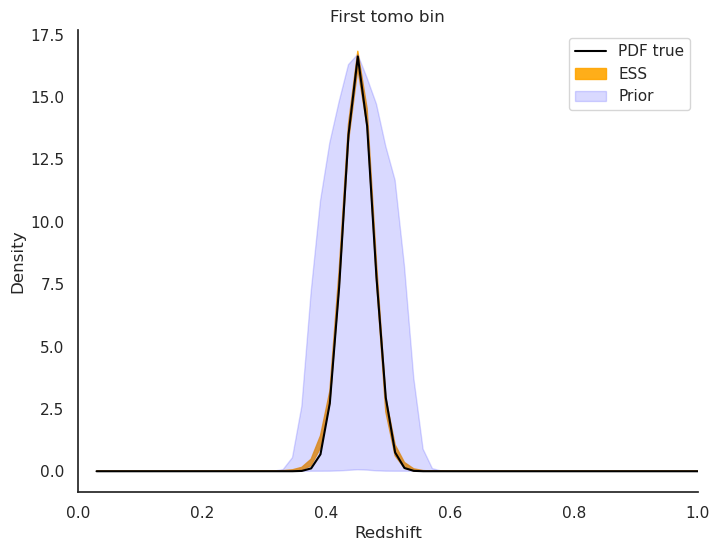

In [15]:
# Configurar el estilo de Seaborn
sns.set_theme(style="white")

colors = sns.color_palette("deep", 4)

# Crear la figura y el eje
plt.figure(figsize=(8, 6))

# Graficar la curva usando Seaborn
sns.lineplot(x=mid, y=nz[0], color="black", label="PDF true")

# Añadir dos regiones sombreadas usando fill_between
plt.fill_between(mid, np.percentile(samples_all[0], 16, axis=0), nn*np.percentile(samples_all[0], 84, axis=0), color="orange", alpha=0.9, label="ESS")
plt.fill_between(mid, np.percentile(qrand_sample, 16, axis=0), np.percentile(qrand_sample, 84, axis=0), color="blue", alpha=0.15, label="Prior")


# Añadir etiquetas y leyendas
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.title("First tomo bin")
plt.legend()
plt.xlim([0, 1])

sns.despine() # Eliminar bordes de los plots

plt.savefig("plots/prior_and_ESS.pdf", format="pdf")

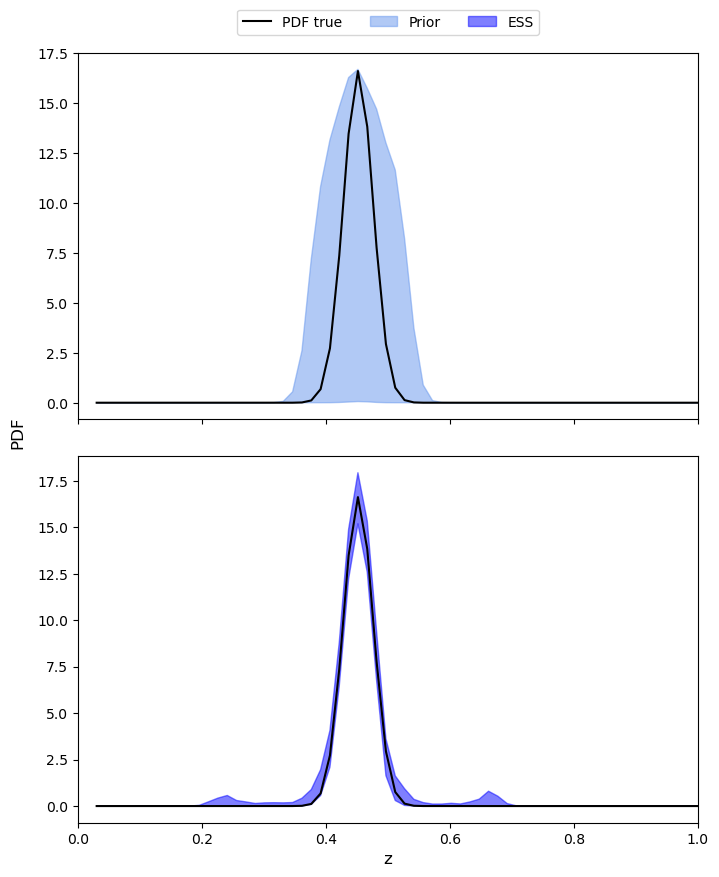

In [41]:
fig, ax = plt.subplots(2, 1, sharex="col", sharey="row", figsize=(8,10))
fig.subplots_adjust(wspace=0, hspace=0.1)

ax[0].plot(mid, nz[0], 'k')
ax[0].fill_between(mid, np.percentile(qrand_sample, 16, axis=0), np.percentile(qrand_sample, 84, axis=0), color='cornflowerblue', alpha = 0.5)
ax[0].set_xlim(0, 1)

ax[1].fill_between(mid, np.percentile(samples_all[0], 0, axis=0), nn*np.percentile(samples_all[0], 100, axis=0), color='blue', alpha=0.5)
ax[1].set_xlim(0, 1)
ax[1].plot(mid, nz[0], 'k')

textsize = 12
ax[1].set_xlabel('z',  fontsize=textsize)
fig.text(0.04, 0.5, 'PDF', va='center', rotation='vertical', fontsize=textsize)

# define the name of the 
legend_labels = ("PDF true", "Prior", "ESS")
# set figure legend entries, number of columns, location
#fig.legend(legend_labels, ncol = len(legend_labels), loc="upper center")
fig.legend(legend_labels, ncol = len(legend_labels), bbox_to_anchor=(0.71, 0.93))



#plt.savefig("plots/prior_samples.pdf", format="pdf")
plt.show()

In [ ]:
1+1